### Code for generating 20 News dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_recall_curve, roc_curve
from sklearn.ensemble import RandomForestClassifier

In [2]:
#preamble
%matplotlib inline
from IPython.display import set_matplotlib_formats, display
#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from cycler import cycler

set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['image.cmap'] = "viridis"
plt.rcParams['image.interpolation'] = "none"
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.numpoints'] = 1
plt.rc('axes', prop_cycle=(
    cycler('color', mglearn.plot_helpers.cm_cycle.colors) +
    cycler('linestyle', ['-', '-', "--", (0, (3, 3)), (0, (1.5, 1.5))])))

np.set_printoptions(precision=3, suppress=True)

#pd.set_option("display.max_columns", 8)
#pd.set_option('precision', 2)

__all__ = ['np', 'mglearn', 'display', 'plt', 'pd']


In [3]:
news = fetch_20newsgroups(subset='train')
Text_train = news.data
Y_train = news.target

news_test = fetch_20newsgroups(subset='test')
Text_test = news_test.data
Y_test = news_test.target

In [4]:
processor = CountVectorizer(max_features=5000, stop_words='english')
processor.fit(Text_train)
Sparse_train = processor.transform(Text_train)
Sparse_test = processor.transform(Text_test)

In [5]:
X_train = np.array(Sparse_train.todense())
X_test = np.array(Sparse_test.todense())

In [6]:
labels = news.target_names
vocabulary = processor.vocabulary_

#### Dataset with:

X_train, X_test, Y_train, Y_test, labels, vocabulary

# Train a linear classifier on the 20 News data and compute training accuracy

In [7]:
models = {
    'LogisticRegression': LogisticRegression()
    ,'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=0, max_features=20)
    #,'KNeighborsClassifier3': KNeighborsClassifier(n_neighbors=3)
}

In [8]:
regressors = {}
for name, model in models.items():
    reg = model.fit(X_train, Y_train)
    regressors[name] = reg
    # evaluate the model on the training set
    print("Training set score for {}: {:.2f}".format(name, reg.score(X_train, Y_train)))

Training set score for LogisticRegression: 1.00
Training set score for RandomForestClassifier: 1.00


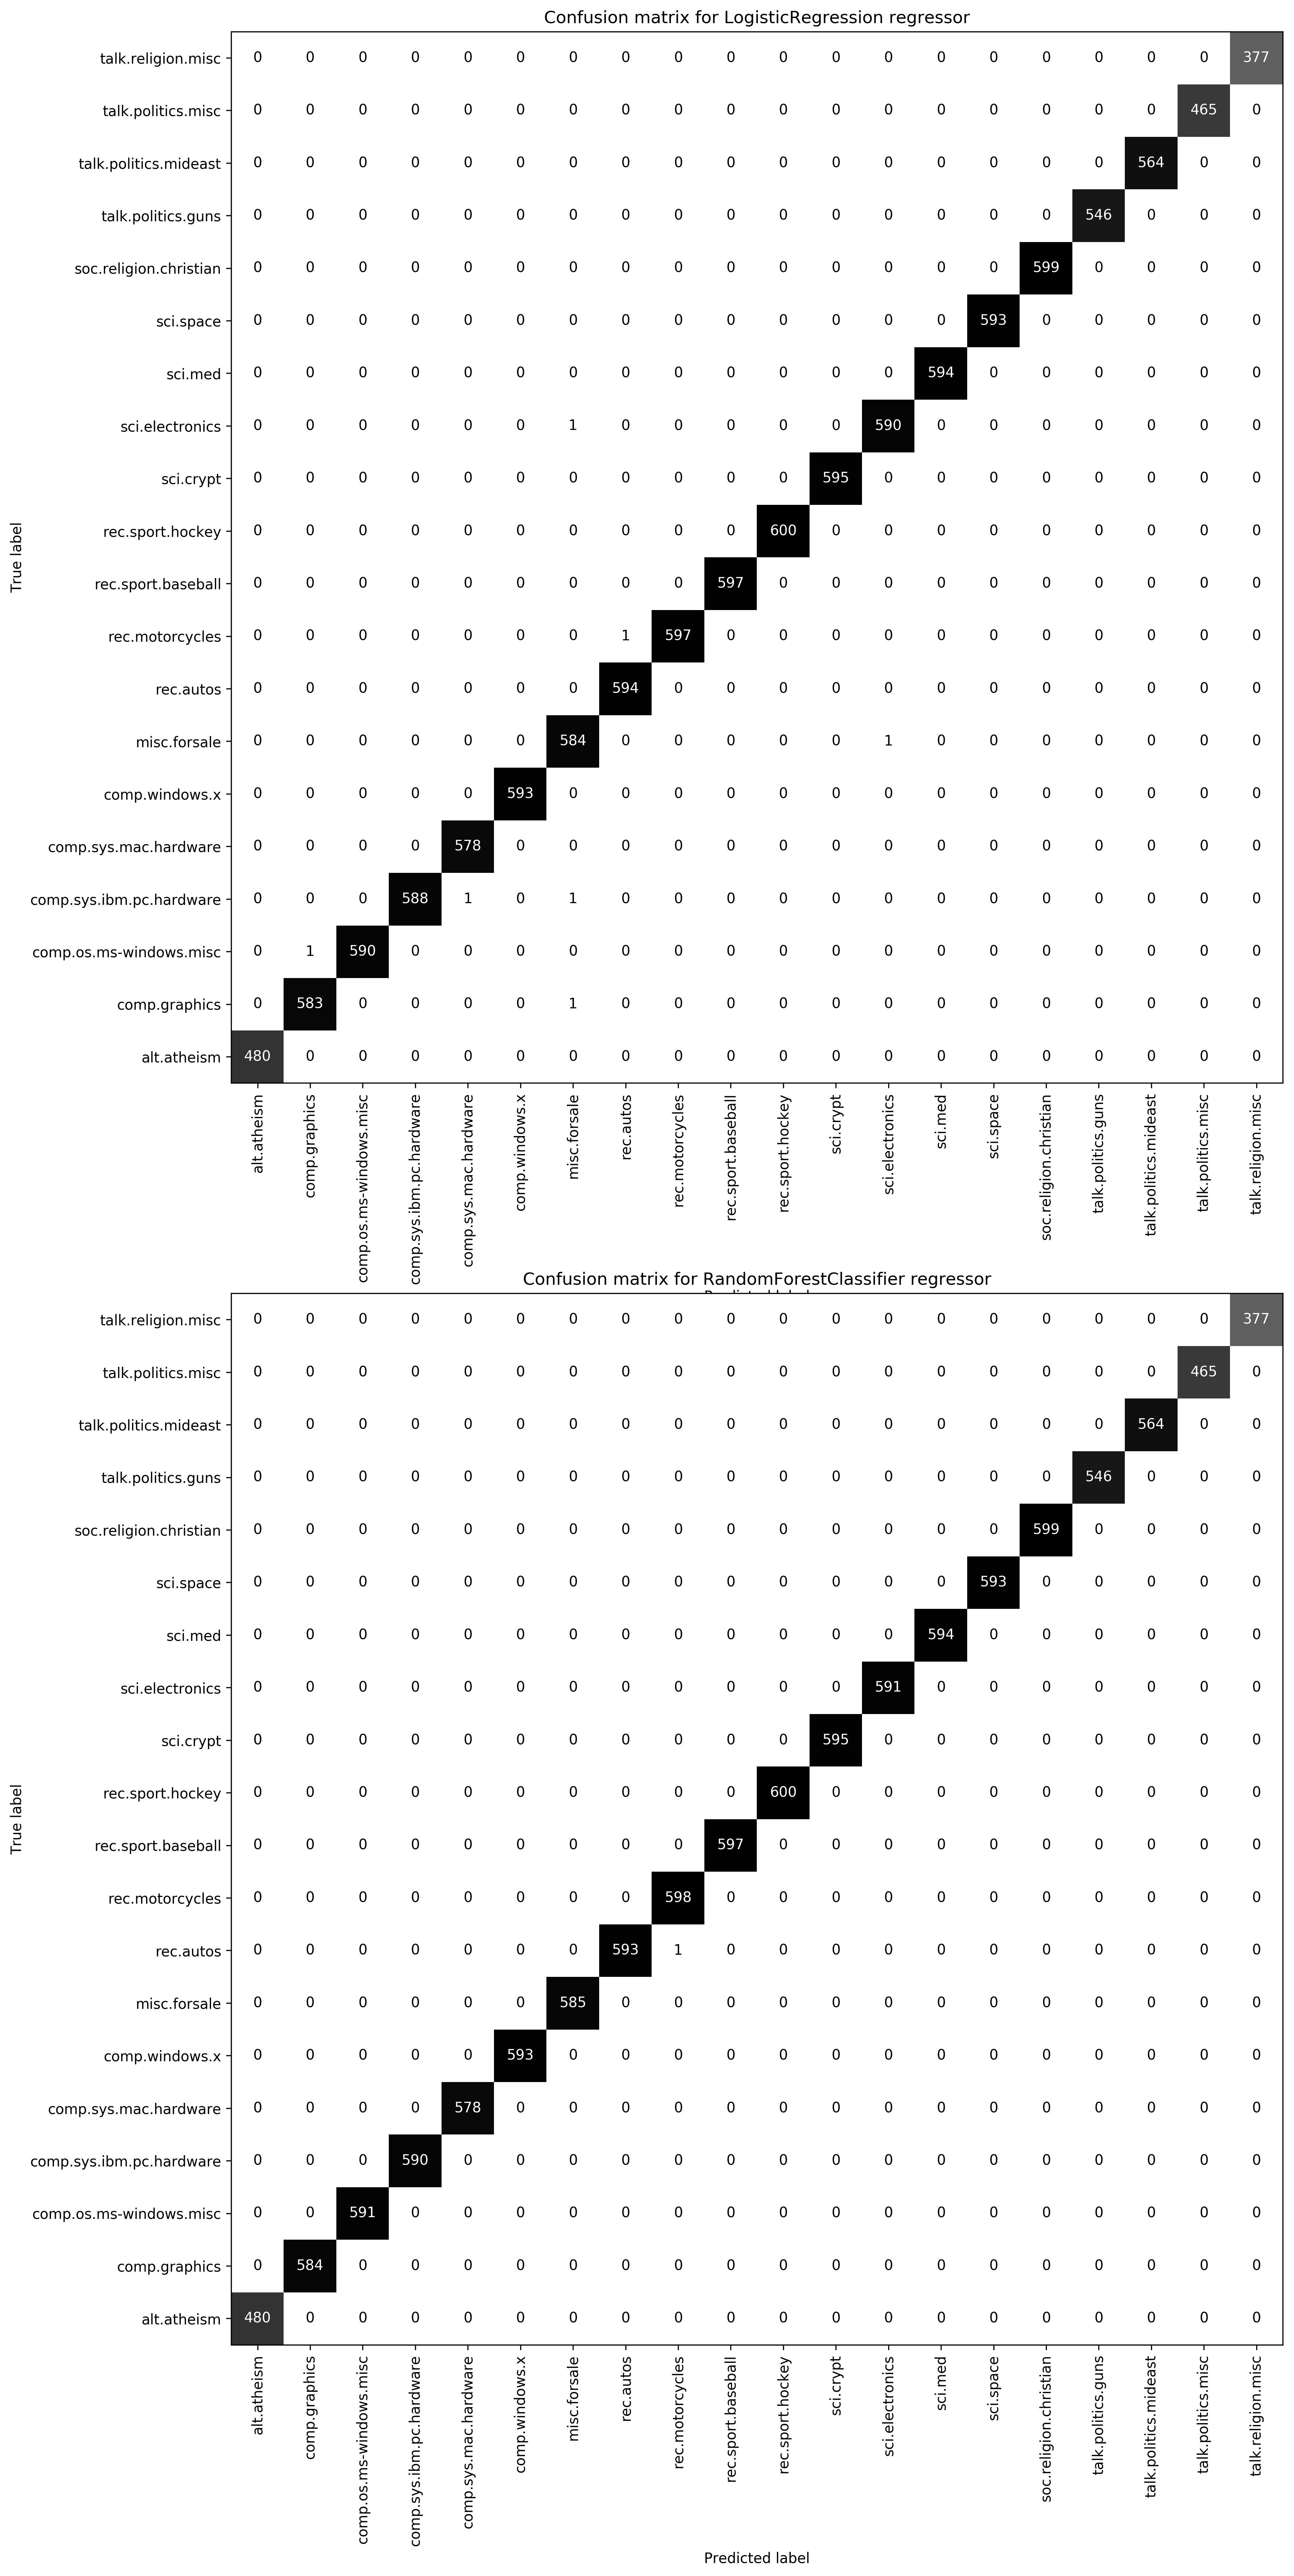

In [9]:
plt.clf()
rows = len(regressors)
columns = 1
fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15,15 * rows))
if columns * rows > 1:
    axes = axes.flatten()

ax_counter = 0

for name, reg in regressors.items():
    preds = reg.predict(X_train)
    confusion = confusion_matrix(Y_train, preds)
    
    ax = axes[ax_counter]
    ax_counter += 1

    scores_image = mglearn.tools.heatmap(
        confusion, xlabel='Predicted label',
        ylabel='True label', xticklabels=labels,
        yticklabels=labels, ax=ax, cmap=plt.cm.gray_r, fmt="%d")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set_title("Confusion matrix for {} regressor".format(name))
    plt.gca().invert_yaxis()

# Estimate generalization accuracy with a 3-fold cross-validation

In [10]:
logreg = LogisticRegression()
scores = cross_val_score(logreg, X_train, Y_train, cv=3)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.855  0.863  0.852]


In [11]:
kfold = KFold(n_splits=3, shuffle=True, random_state=0)
scores = cross_val_score(logreg, X_train, Y_train, cv=kfold)
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [ 0.851  0.845  0.855]


# Print a confusion matrix with names of news groups on X- and Y-axes

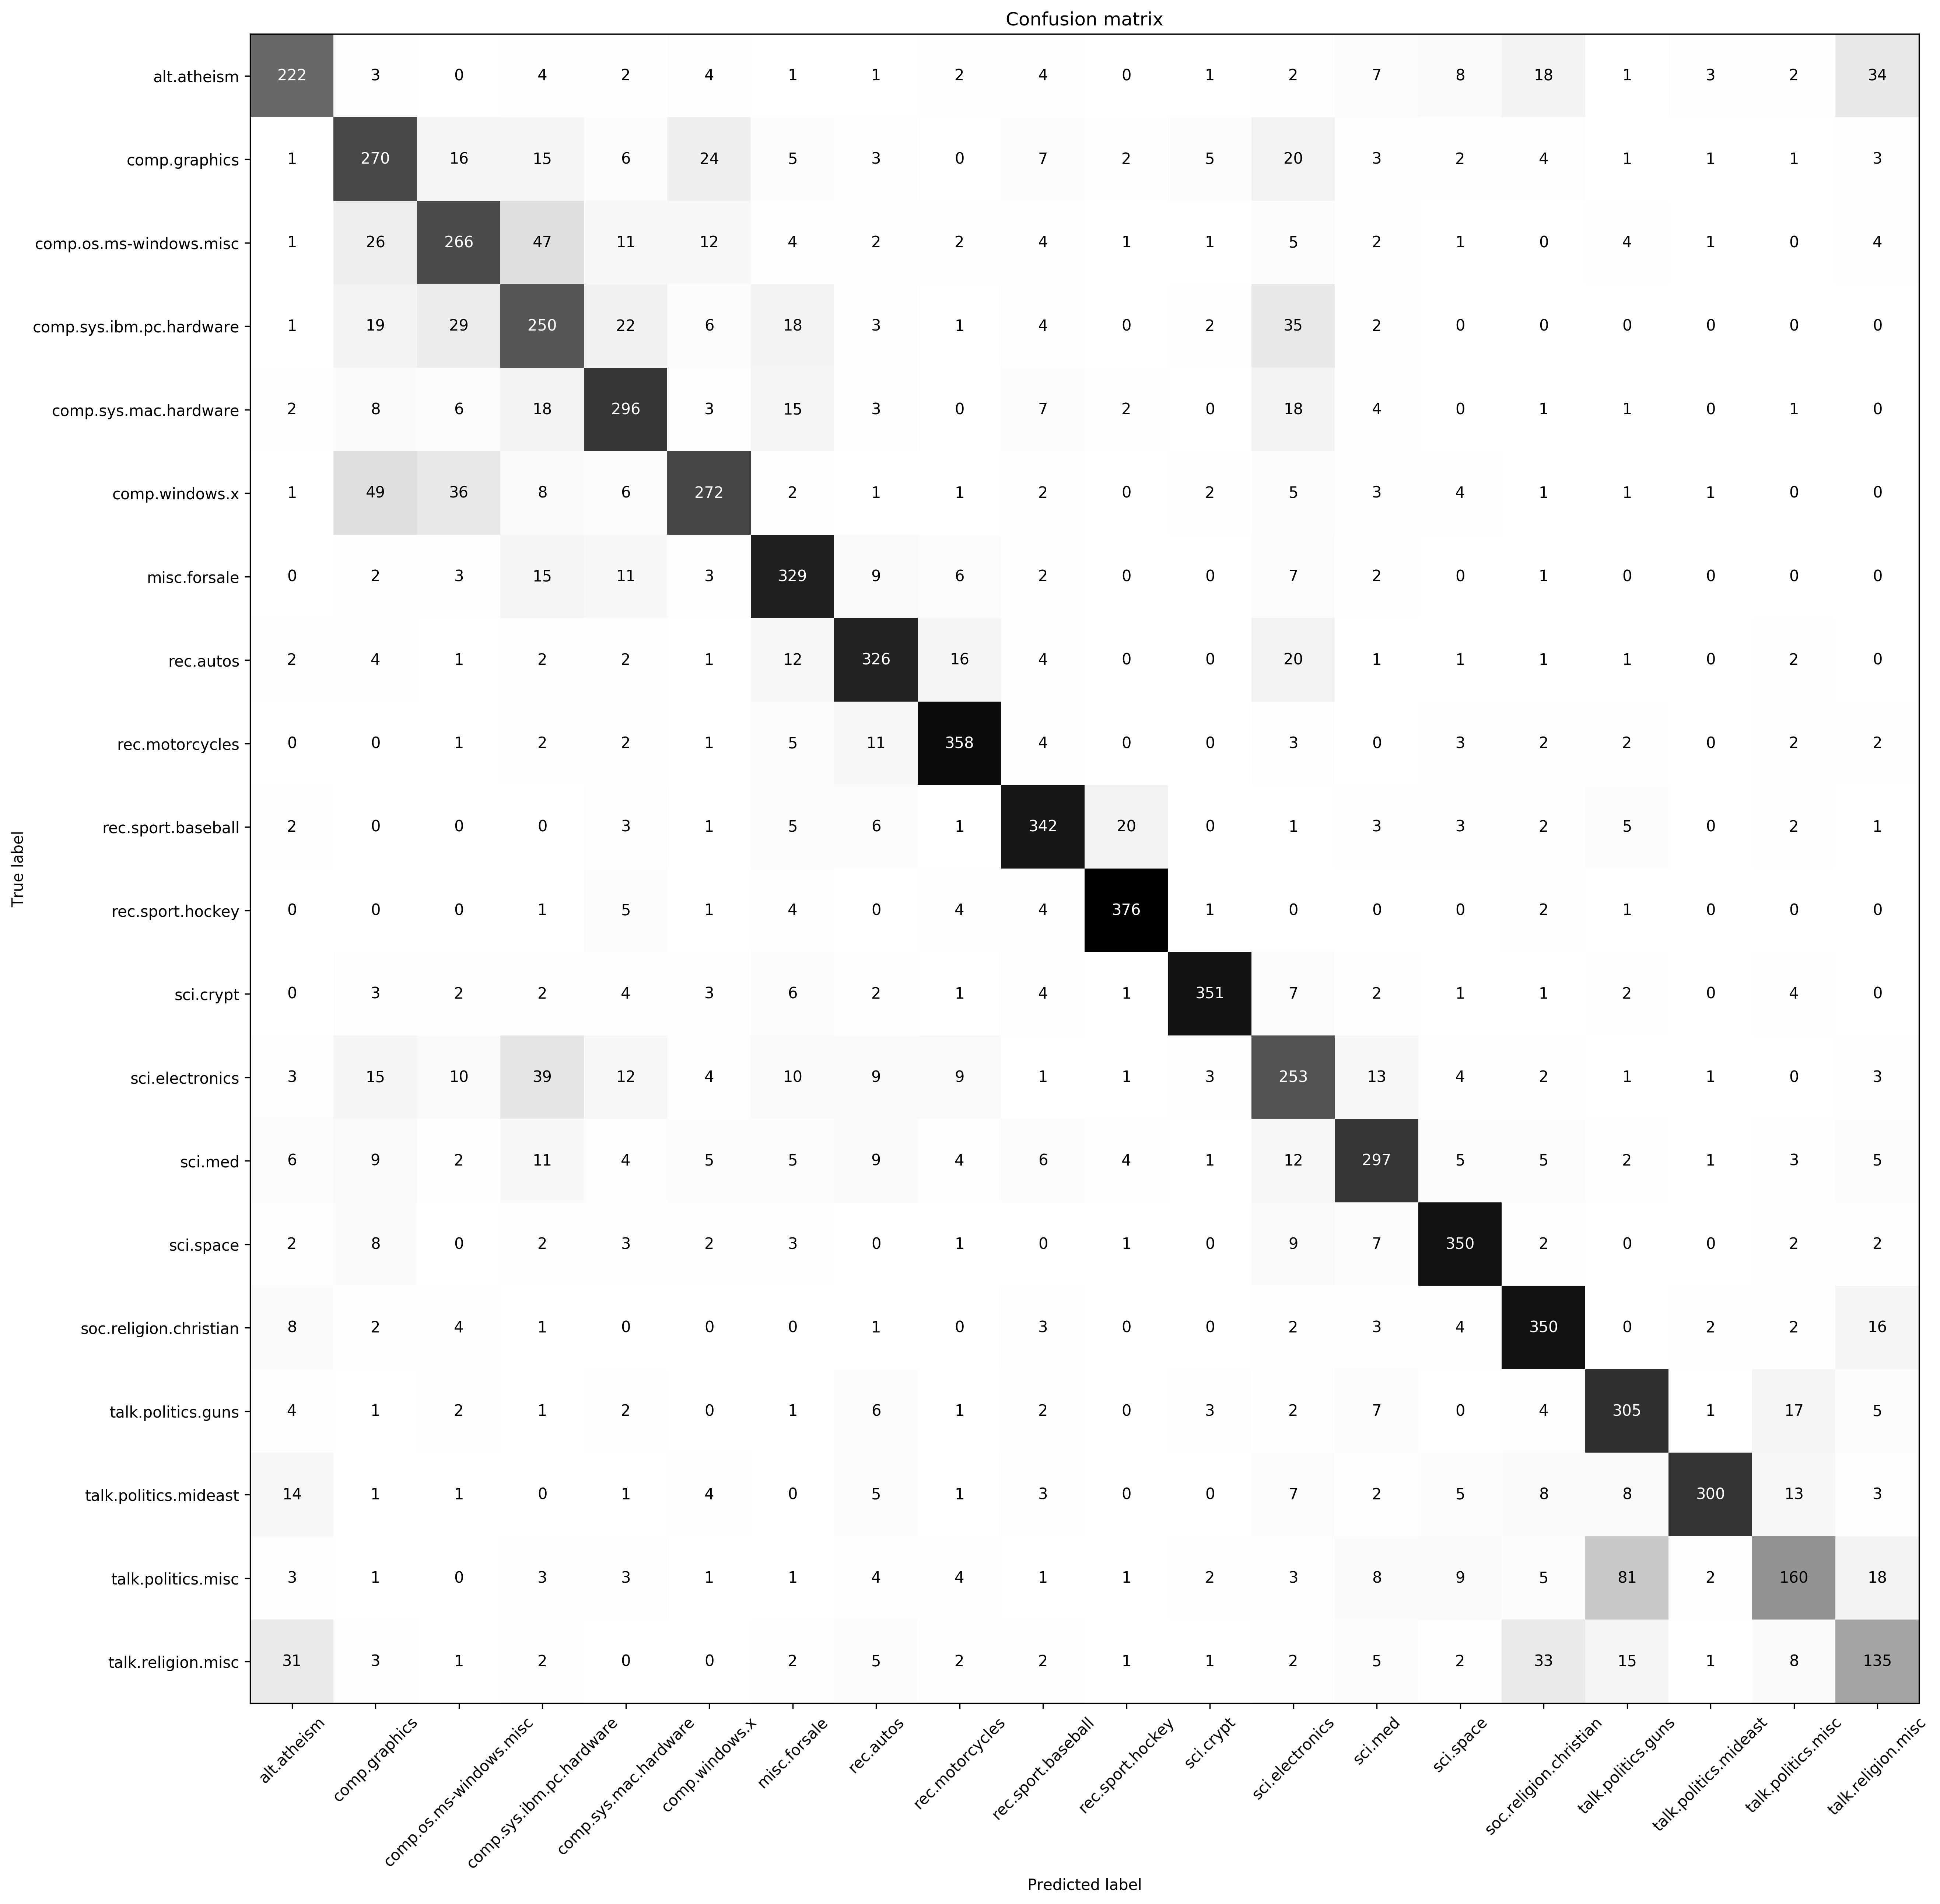

In [12]:
logreg.fit(X_train, Y_train)
pred_logreg = logreg.predict(X_test)
confusion = confusion_matrix(Y_test, pred_logreg)
plt.clf()
#ax = plt.gca()
rows = 1
columns = 1
fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,20))
if columns * rows > 1:
    ax = ax.flatten()

scores_image = mglearn.tools.heatmap(
    confusion, xlabel='Predicted label',
    ylabel='True label', xticklabels=labels,
    yticklabels=labels, ax=ax, cmap=plt.cm.gray_r, fmt="%d")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

# Build a binary classifier to separate *misc.forsale* news from the rest.

In [13]:
binary_target = 'misc.forsale'
binary_target_index = -1
for i in range(len(labels)):
    if labels[i] == binary_target:
        binary_target_index = i

bin_y_train = Y_train == binary_target_index
bin_y_test = Y_test == binary_target_index

## Logistic Regression

In [14]:
logreg = LogisticRegression()
logreg.fit(X_train, bin_y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, bin_y_test)))

Test score: 0.98


(0, 1)

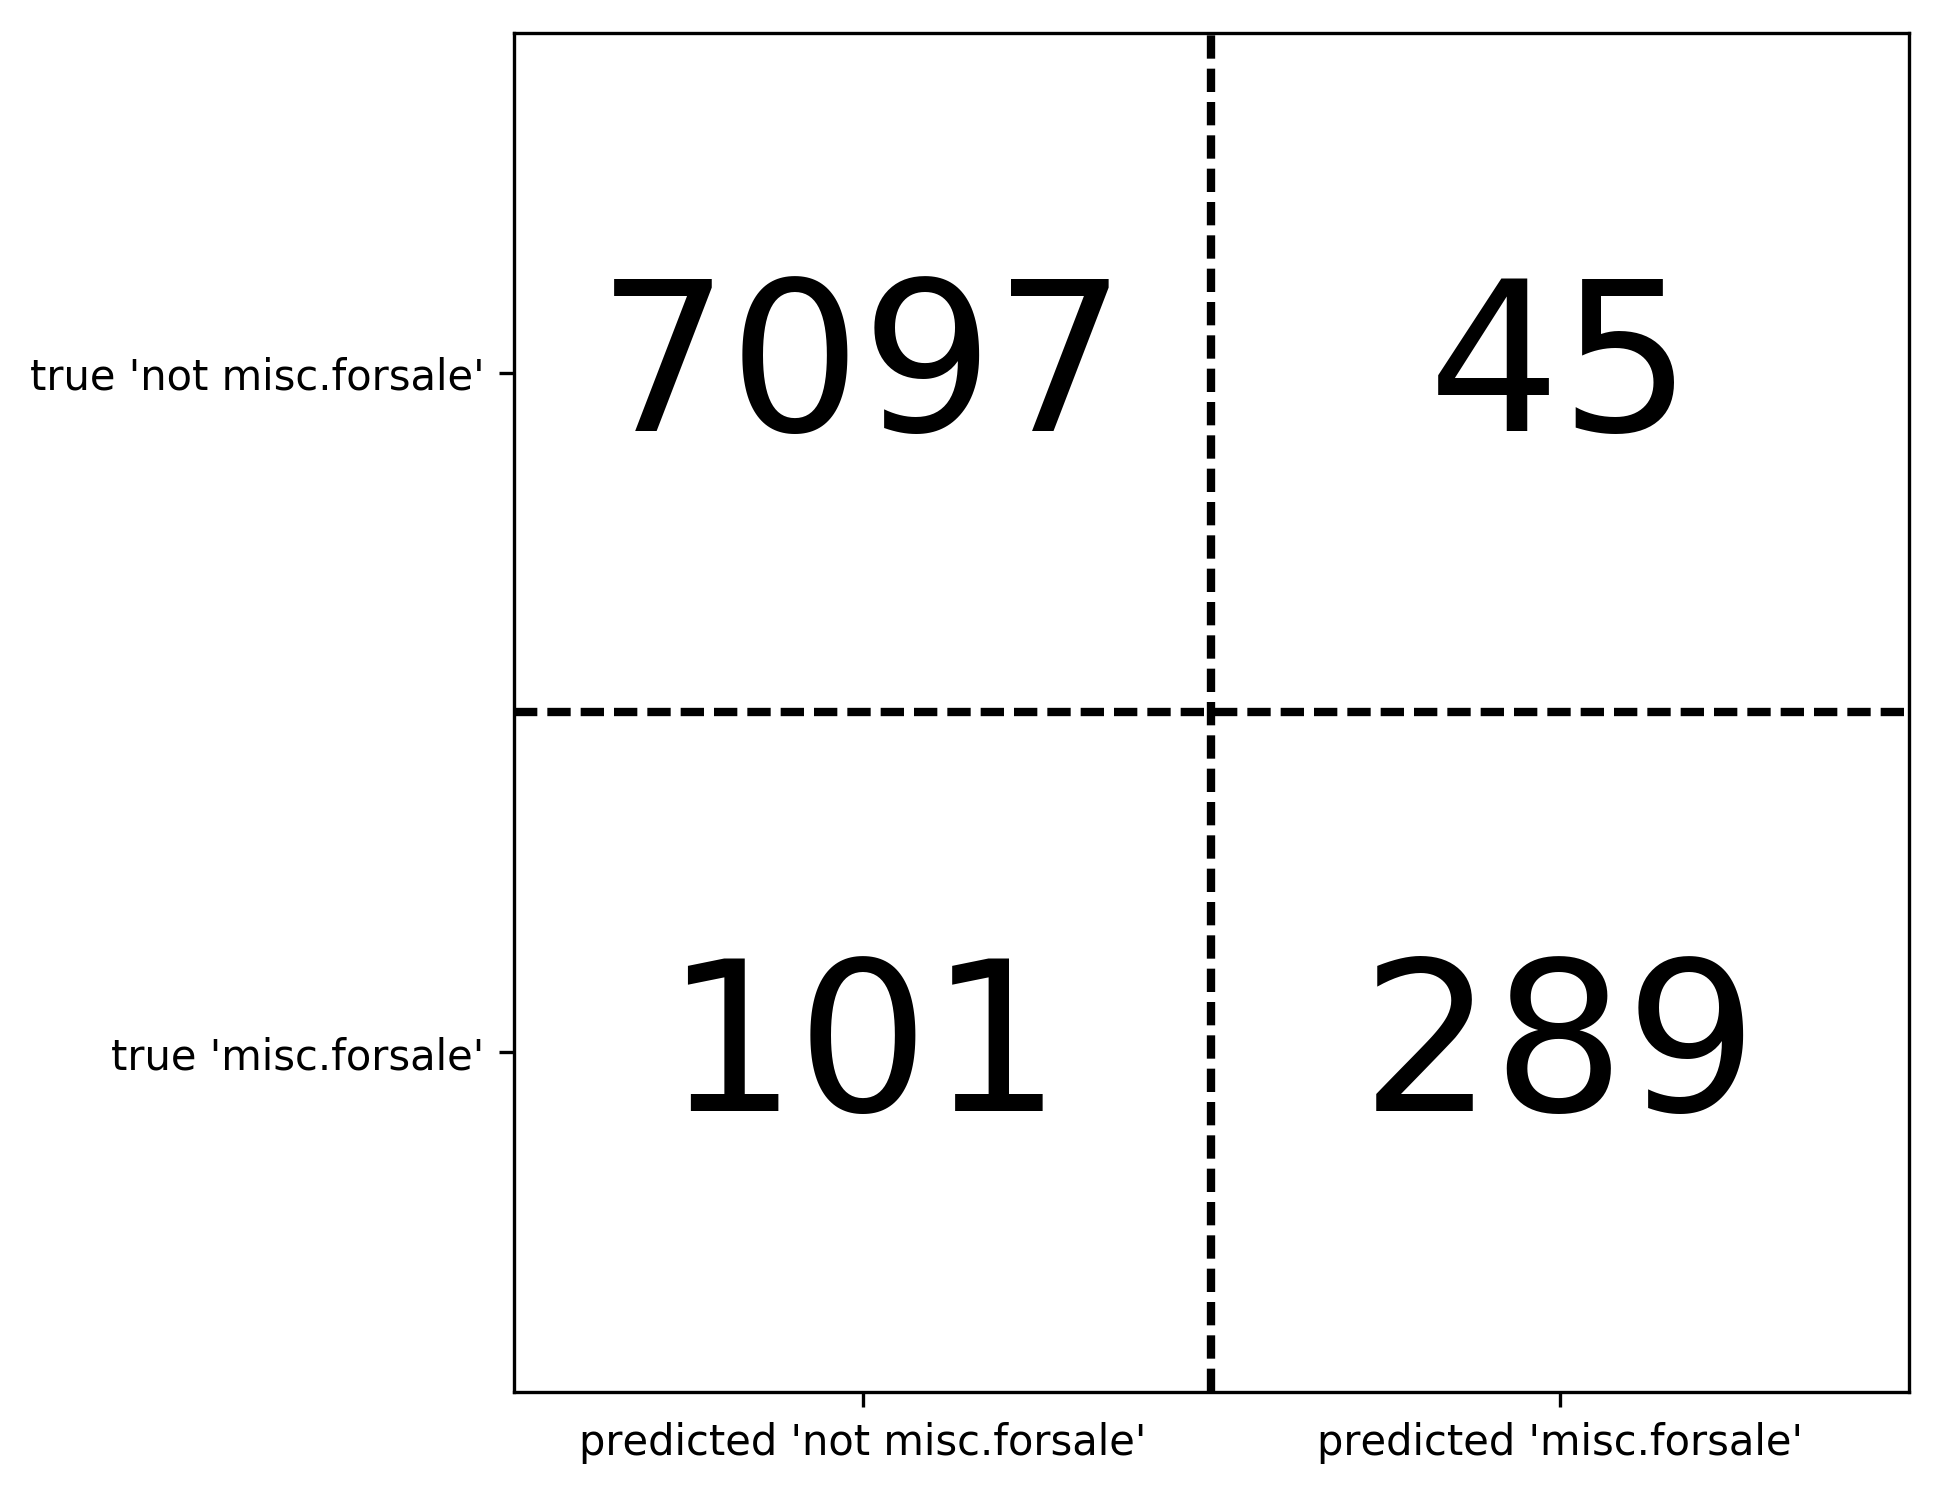

In [15]:
preds = logreg.predict(X_test)
confusion = confusion_matrix(bin_y_test, preds)
x_labels = ["predicted 'not {}'".format(binary_target), "predicted '{}'".format(binary_target)]
y_labels = ["true '{}'".format(binary_target), "true 'not {}'".format(binary_target)]
plt.figure(figsize=(6, 6))
plt.text(0.25, .75, confusion[0, 0], size=50, horizontalalignment='center', verticalalignment='center')
plt.text(0.25, .25, confusion[1, 0], size=50, horizontalalignment='center', verticalalignment='center')
plt.text(.75, .75, confusion[0, 1], size=50, horizontalalignment='center', verticalalignment='center')
plt.text(.75, 0.25, confusion[1, 1], size=50, horizontalalignment='center', verticalalignment='center')
plt.xticks([.25, .75], x_labels, size=10)
plt.yticks([.25, .75], y_labels, size=10)
plt.plot([.5, .5], [0, 1], '--', c='k')
plt.plot([0, 1], [.5, .5], '--', c='k')

plt.xlim(0, 1)
plt.ylim(0, 1)

## Random Forest Classifier

In [16]:
rf = RandomForestClassifier(n_estimators=100, random_state=0, max_features=20)
rf.fit(X_train, bin_y_train)
print("Test score: {:.2f}".format(rf.score(X_test, bin_y_test)))

Test score: 0.96


(0, 1)

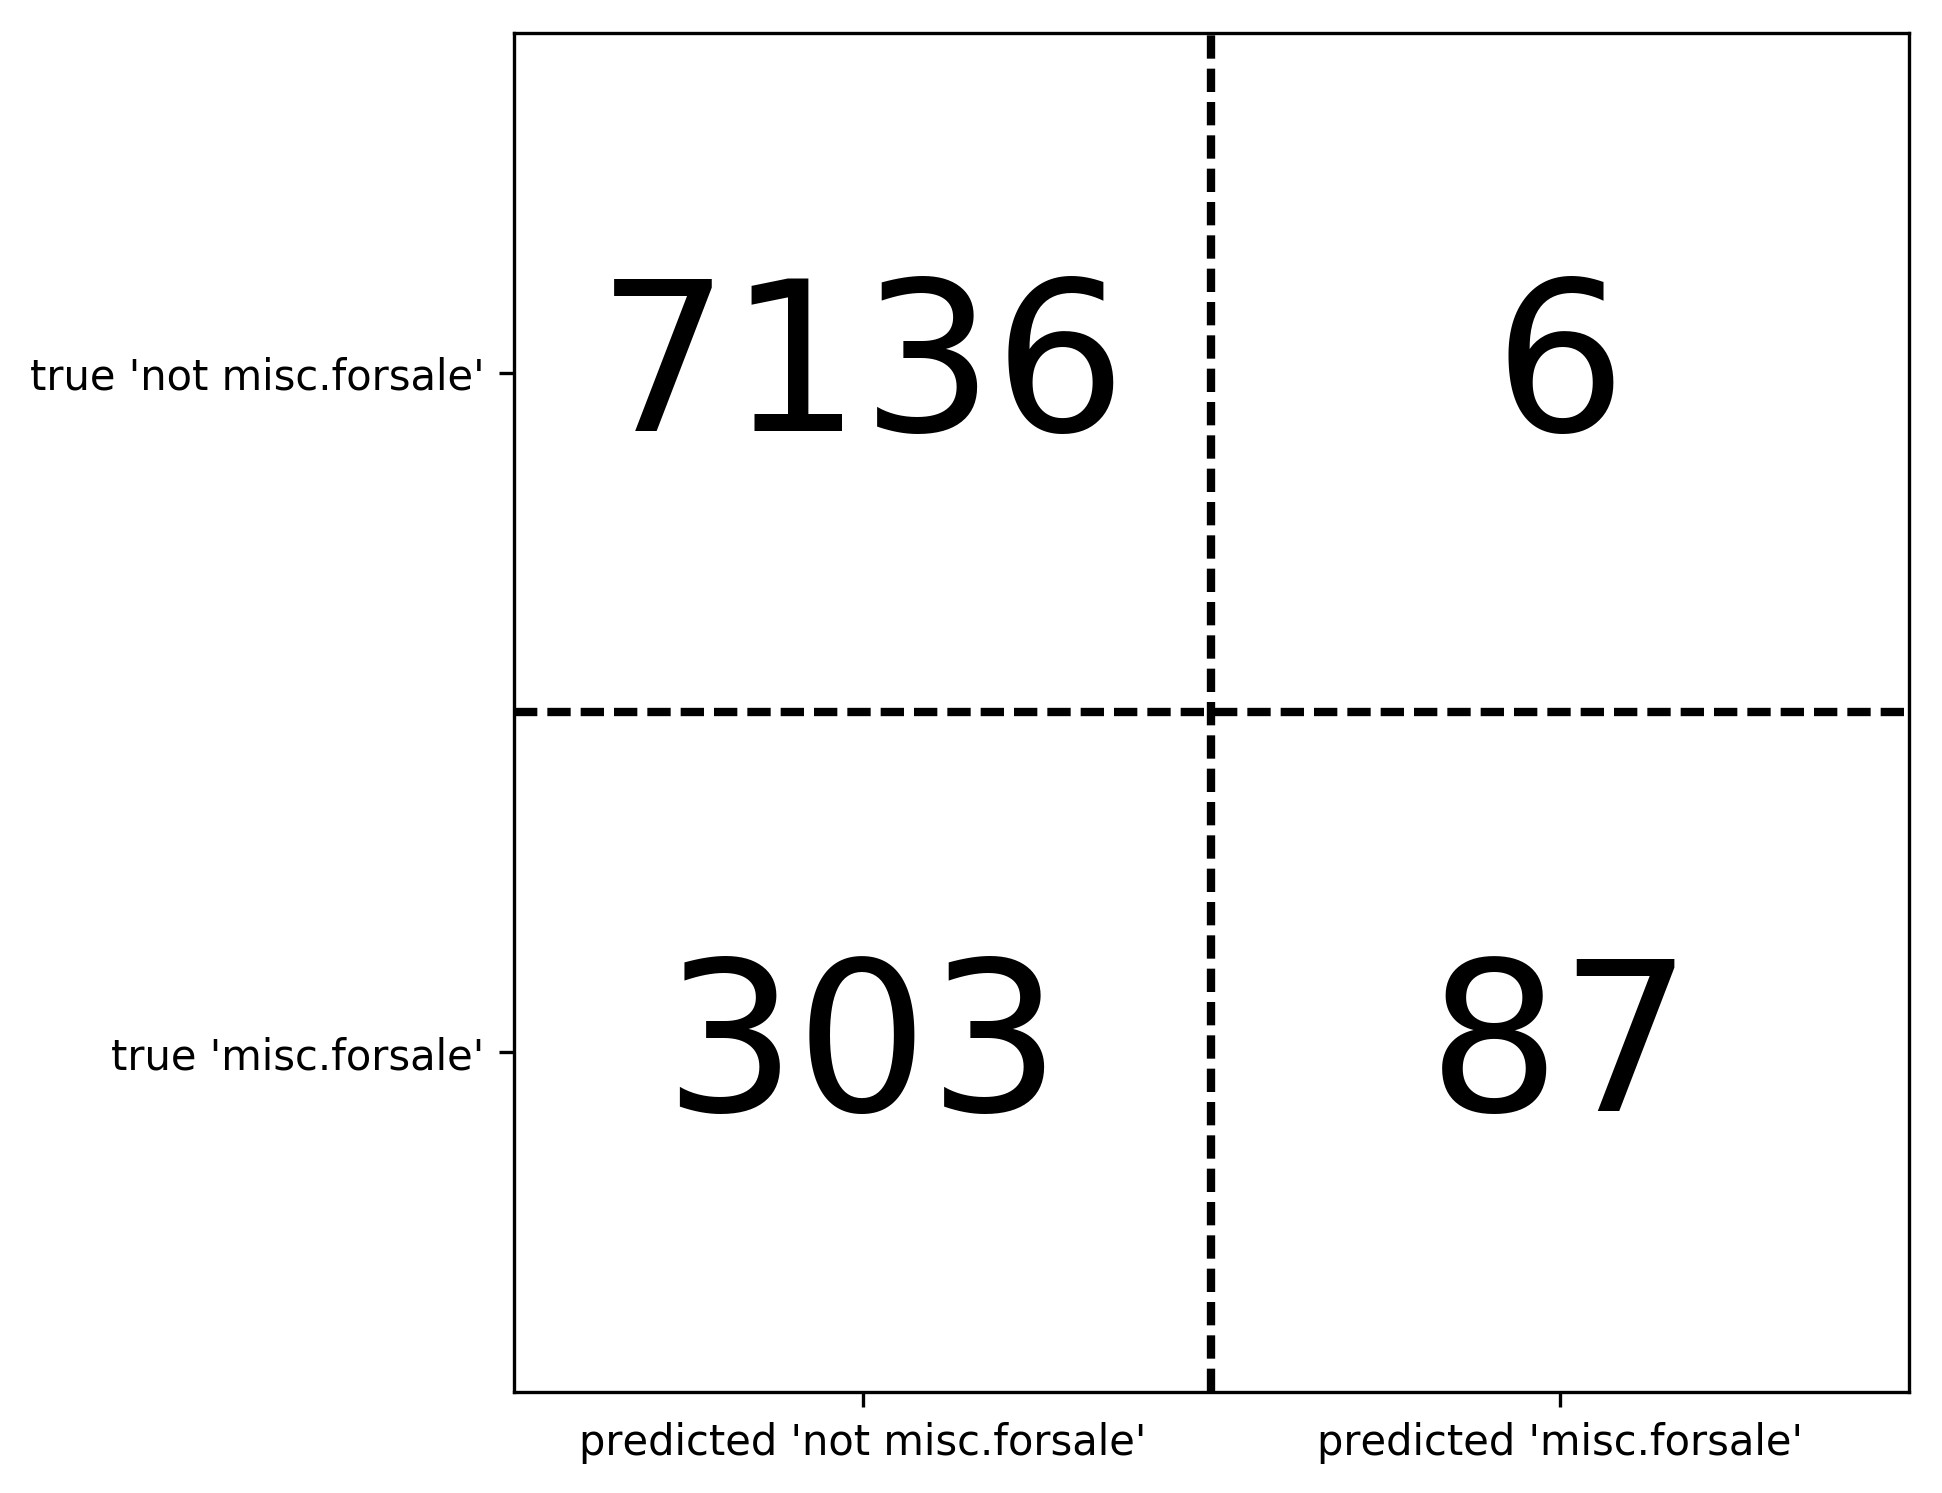

In [17]:
preds = rf.predict(X_test)
confusion = confusion_matrix(bin_y_test, preds)
x_labels = ["predicted 'not {}'".format(binary_target), "predicted '{}'".format(binary_target)]
y_labels = ["true '{}'".format(binary_target), "true 'not {}'".format(binary_target)]
plt.figure(figsize=(6, 6))
plt.text(0.25, .75, confusion[0, 0], size=50, horizontalalignment='center', verticalalignment='center')
plt.text(0.25, .25, confusion[1, 0], size=50, horizontalalignment='center', verticalalignment='center')
plt.text(.75, .75, confusion[0, 1], size=50, horizontalalignment='center', verticalalignment='center')
plt.text(.75, 0.25, confusion[1, 1], size=50, horizontalalignment='center', verticalalignment='center')
plt.xticks([.25, .75], x_labels, size=10)
plt.yticks([.25, .75], y_labels, size=10)
plt.plot([.5, .5], [0, 1], '--', c='k')
plt.plot([0, 1], [.5, .5], '--', c='k')

plt.xlim(0, 1)
plt.ylim(0, 1)

# Print an ROC curve for the binary classifier above

## Logistic Regression

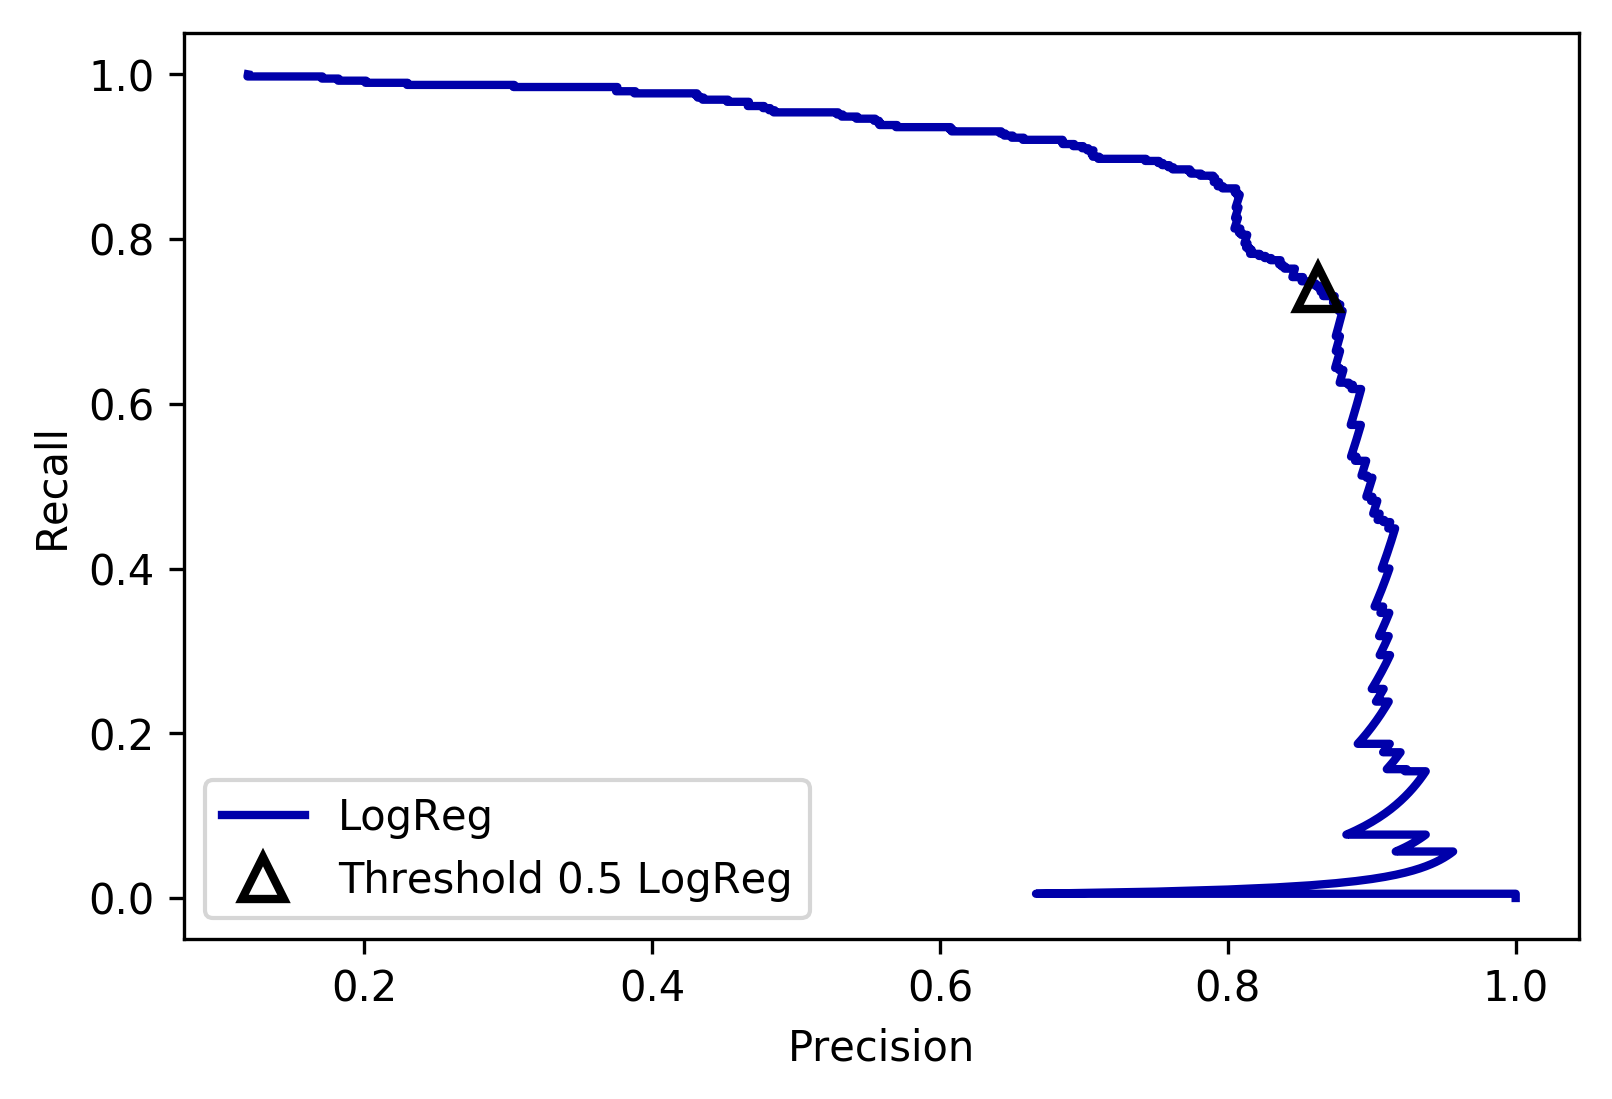

In [18]:
precision_logreg, recall_logreg, thresholds_logreg = precision_recall_curve(bin_y_test, logreg.predict_proba(X_test)[:, 1])

close_default_logreg = np.argmin(np.abs(thresholds_logreg - 0.5))

plt.plot(precision_logreg, recall_logreg, label="LogReg")
plt.plot(precision_logreg[close_default_logreg], recall_logreg[close_default_logreg], '^', c='k',
         markersize=10, label="Threshold 0.5 LogReg", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

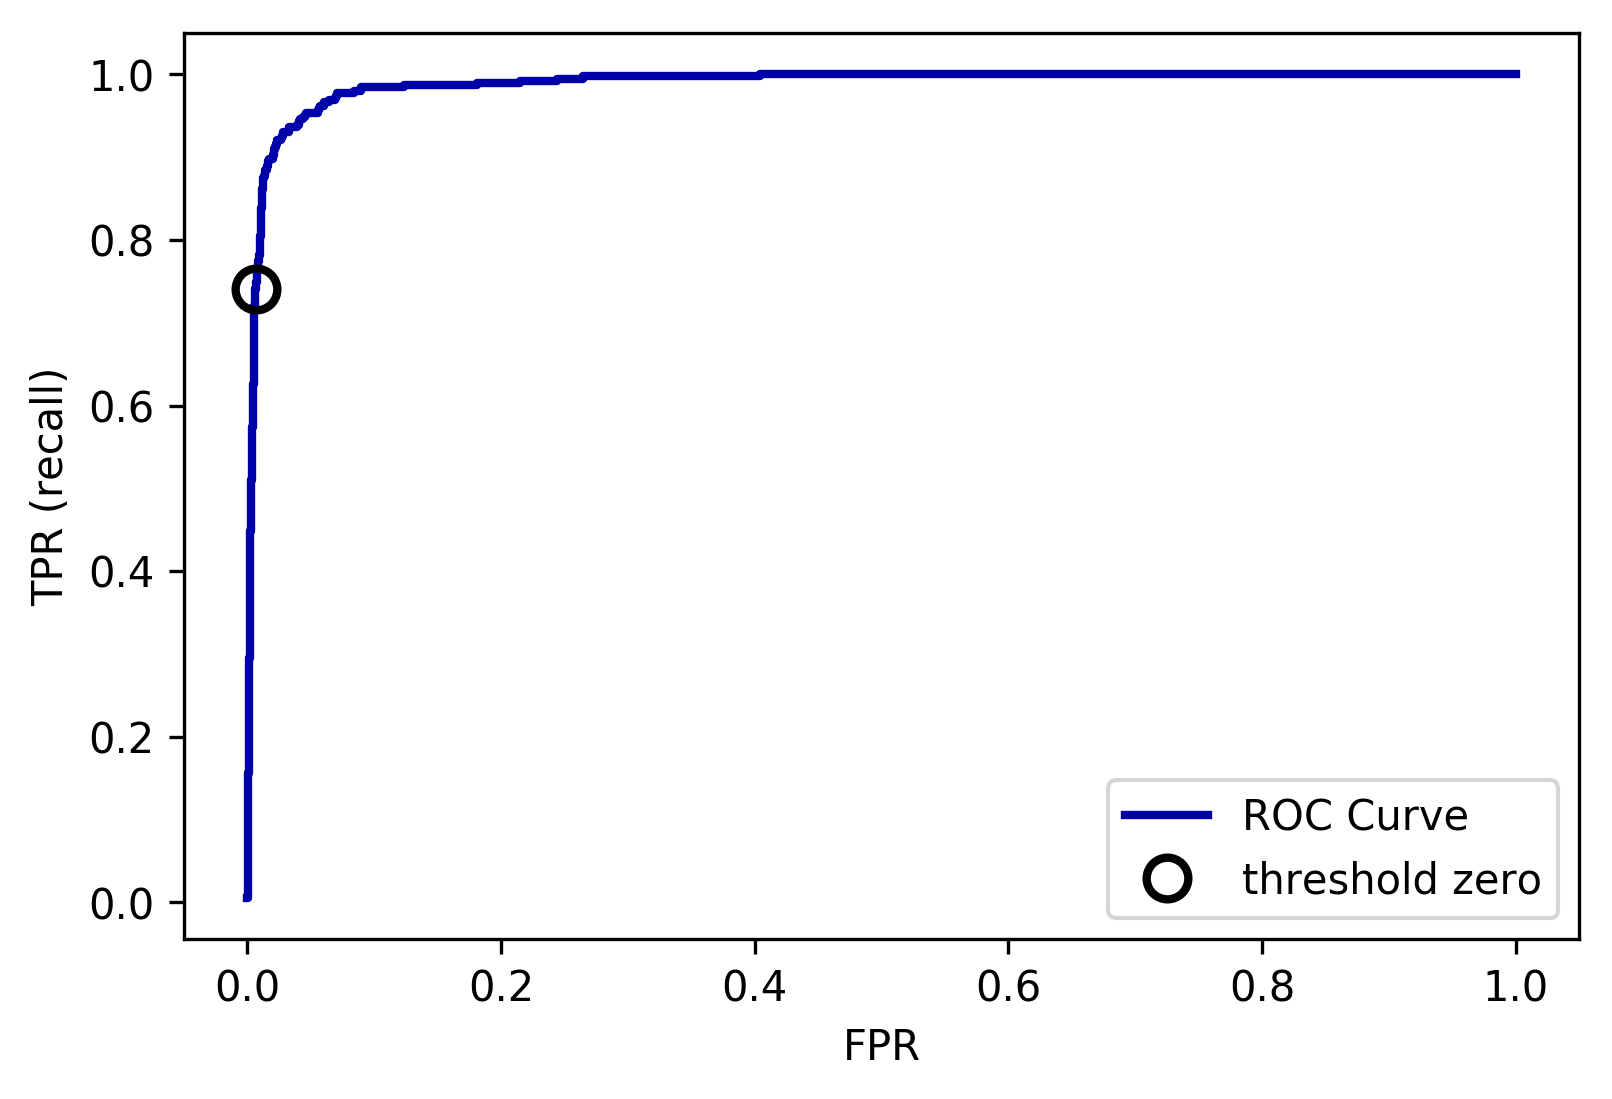

In [19]:
fpr_logreg_roc, tpr_logreg_roc, thresholds_logreg_roc = roc_curve(bin_y_test, logreg.predict_proba(X_test)[:, 1])

plt.plot(fpr_logreg_roc, tpr_logreg_roc, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_default_logreg_roc = np.argmin(np.abs(thresholds_logreg_roc - 0.5))
plt.plot(fpr_logreg_roc[close_default_logreg_roc], tpr_logreg_roc[close_default_logreg_roc], 'o', markersize=10,
         label="threshold zero", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)

## Random Forest Classifier

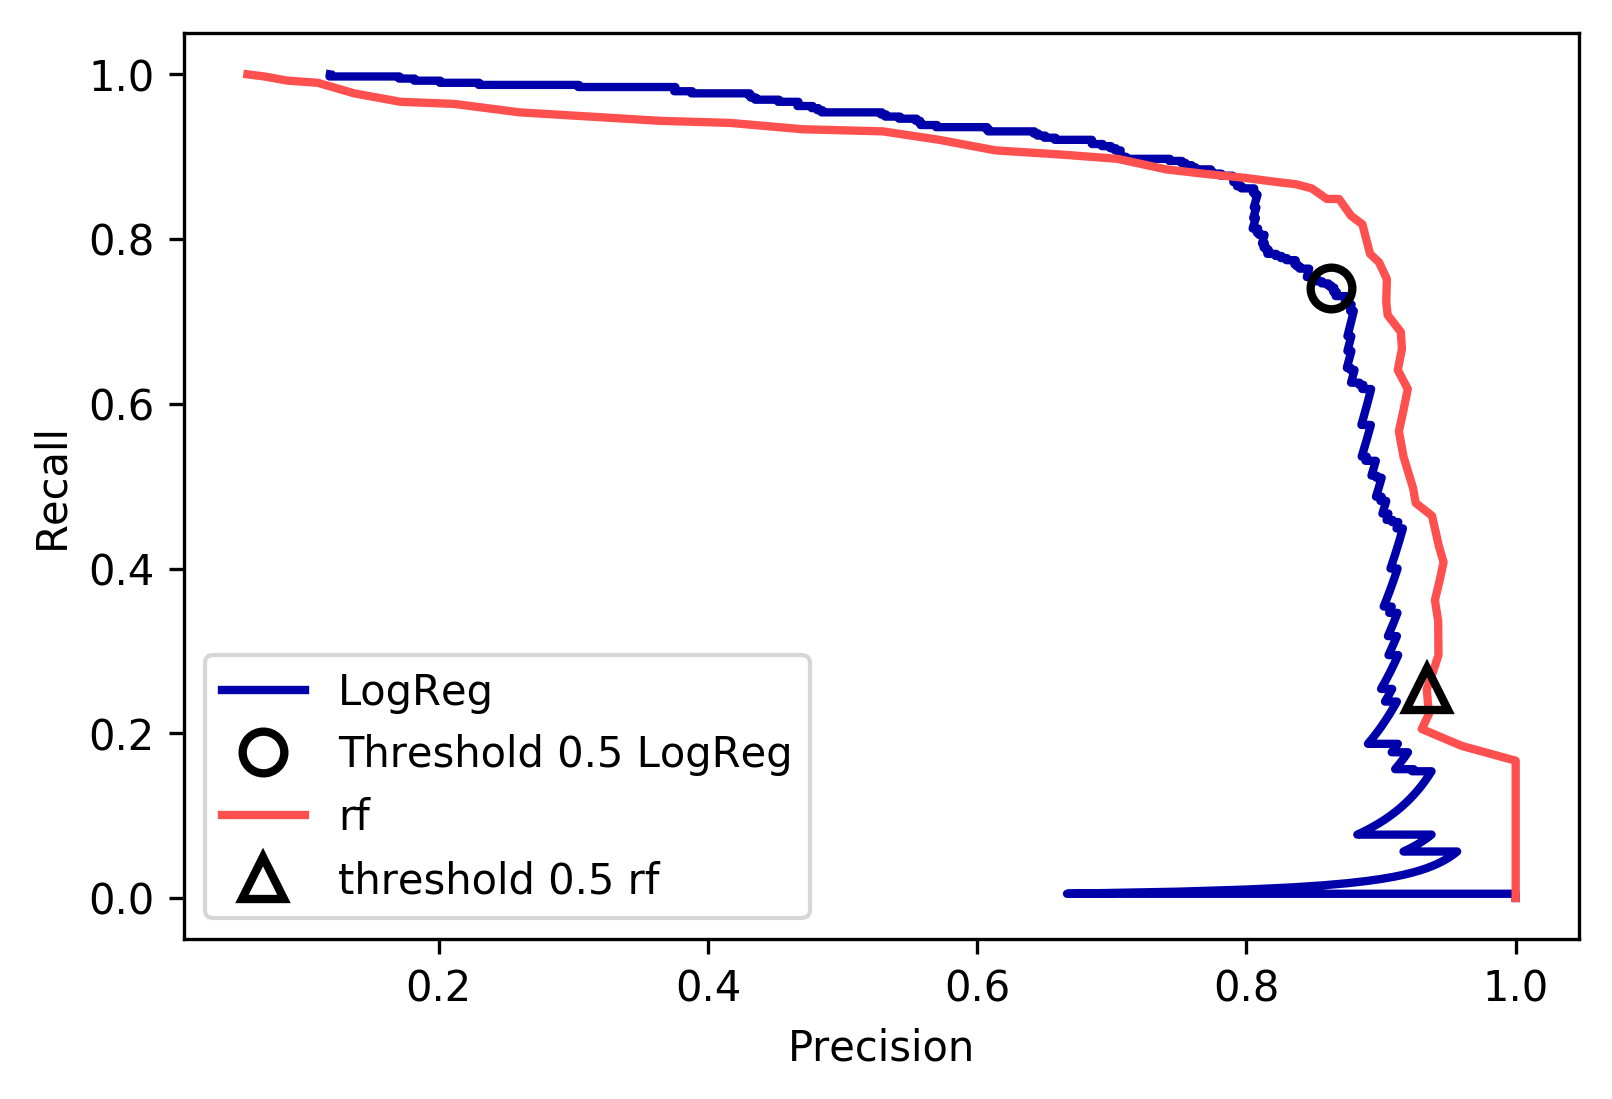

In [20]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(bin_y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(precision_logreg, recall_logreg, label="LogReg")
plt.plot(precision_logreg[close_default_logreg], recall_logreg[close_default_logreg], 'o', c='k',
         markersize=10, label="Threshold 0.5 LogReg", fillstyle="none", mew=2)

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))

plt.plot(precision_rf, recall_rf, label="rf")
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best")

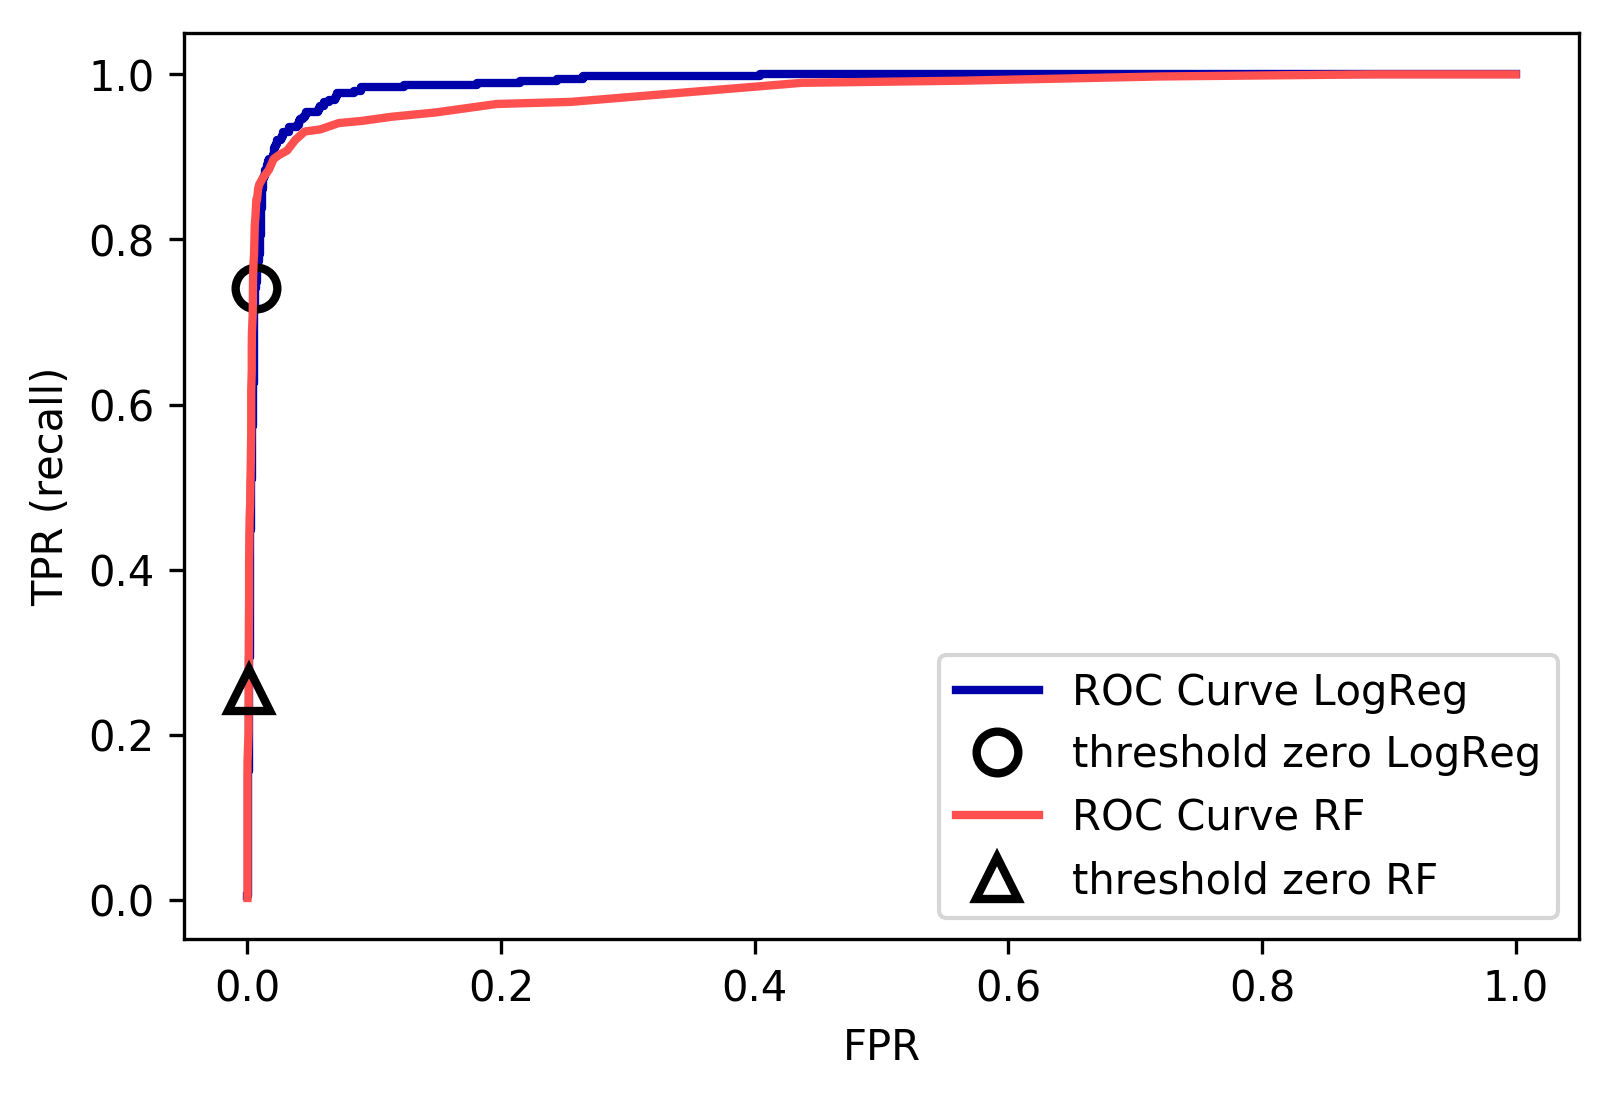

In [21]:
fpr_rf_roc, tpr_rf_roc, thresholds_rf_roc = roc_curve(bin_y_test, rf.predict_proba(X_test)[:, 1])

plt.plot(fpr_logreg_roc, tpr_logreg_roc, label="ROC Curve LogReg")
plt.plot(fpr_logreg_roc[close_default_logreg_roc], tpr_logreg_roc[close_default_logreg_roc], 'o', markersize=10,
         label="threshold zero LogReg", fillstyle="none", c='k', mew=2)

plt.plot(fpr_rf_roc, tpr_rf_roc, label="ROC Curve RF")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero_rf_roc = np.argmin(np.abs(thresholds_rf_roc-0.5))
plt.plot(fpr_rf_roc[close_zero_rf_roc], tpr_rf_roc[close_zero_rf_roc], '^', markersize=10,
         label="threshold zero RF", fillstyle="none", c='k', mew=2)
plt.legend(loc=4)